In [1]:
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
import pandas as pd
import utils
from seaborn import set_theme
set_theme(style = "darkgrid", palette = "dark")

In [2]:
from utils import counting

@counting
def onemax(x):
	return sum(x)

@counting
def deceptive_onemax(x):
	return (sum(x) - 1) % (len(x) + 1)

In [3]:
labels = ("leader", "distribution", "population", "calls")
State = namedtuple("State", labels)

def sample(distribution, k = 1):
	v = np.random.random([k, *distribution.shape])
	if k == 1: v = v[0]
	return np.where(v <= distribution, 1, 0)

def initialize_distribution(chromosome):
	return np.full(chromosome, 0.5)

def best(population, F):
	return max(population, key = F)

def train(algorithm, f, evaluations, **kwargs):
	F = f()
	A = algorithm(F, **kwargs)
	training_data = []
	while F.calls < evaluations:
		training_data.append(next(A))
	return pd.DataFrame.from_records(training_data, columns = labels)

In [4]:
def PBIL(F, chromosome = 256, size = 128, lr = 0.1, mr = 0.1, shift = 0.1):
	distribution = initialize_distribution(chromosome)
	population = sample(distribution, k = size)
	
	while True:
		leader = best(population, F)
		yield State(F(leader), distribution, population, F.calls)
		distribution = (1 - lr)*distribution + lr*leader
		mutations = sample(np.full(chromosome, mr))
		random_bits = sample(np.full(chromosome, 0.5))
		distribution = np.where(
			mutations == 1,
			(1 - shift)*distribution + shift*random_bits,
			distribution
		)
		population = sample(distribution, k = size)

In [5]:
def CGA(F, chromosome = 256, lr = 0.1):
	distribution = initialize_distribution(chromosome)
	population = sample(distribution, k = 2)

	while True:
		w, b = sorted(population, key = F)
		yield State(F(b), distribution.copy(), population, F.calls)
		distribution += (b - w) * lr
		population = sample(distribution, k = 2)

In [6]:
def UMDA(F, chromosome = 256, size = 128, sample_fraction = 0.5):
	M = int(size * sample_fraction)
	distribution = initialize_distribution(chromosome)
	population = sample(distribution, k = size)

	while True:
		ps = sorted(population, key = F)[-M:]
		yield State(F(best(ps, F)), distribution, population, F.calls)
		distribution = np.mean(ps, axis=0)
		population = sample(distribution, k = size)

## Benchmarks

In [8]:
def test(algorithm, f, evaluations = 10000, N = 10, **kwargs):
	calls = []
	leads = []
	for i in range(N):
		data = train(algorithm, f, evaluations, **kwargs)
		calls.append(data["calls"].to_numpy())
		leads.append(data["leader"].to_numpy())
	return np.mean(calls, axis=0), np.mean(leads, axis=0)

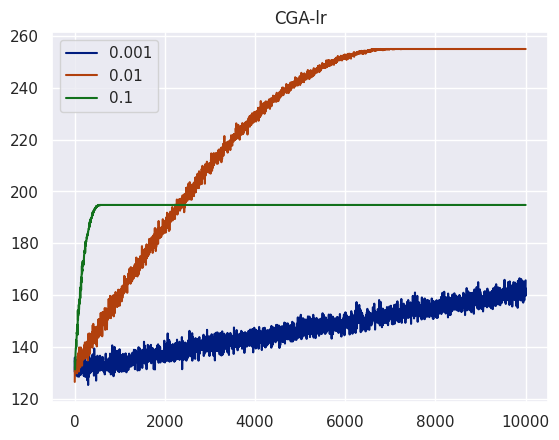

In [15]:
plt.plot(*test(CGA, deceptive_onemax, lr=0.001), label="0.001")
plt.plot(*test(CGA, deceptive_onemax, lr=0.01), label="0.01")
plt.plot(*test(CGA, deceptive_onemax, lr=0.1), label="0.1")
plt.title("CGA-lr")
plt.legend()
plt.show()

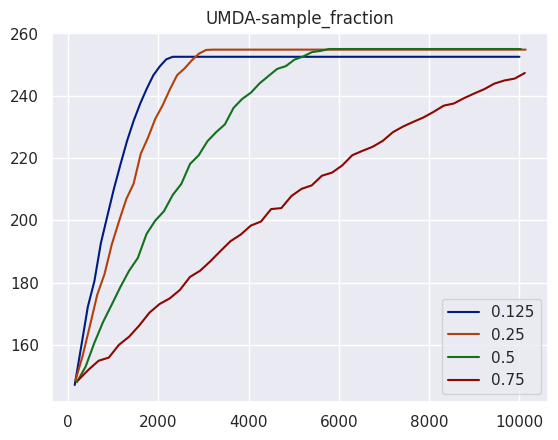

In [13]:
plt.plot(*test(UMDA, deceptive_onemax, sample_fraction=0.125), label="0.125")
plt.plot(*test(UMDA, deceptive_onemax, sample_fraction=0.25), label="0.25")
plt.plot(*test(UMDA, deceptive_onemax, sample_fraction=0.5), label="0.5")
plt.plot(*test(UMDA, deceptive_onemax, sample_fraction=0.75), label="0.75")
plt.title("UMDA-sample_fraction")
plt.legend()
plt.show()

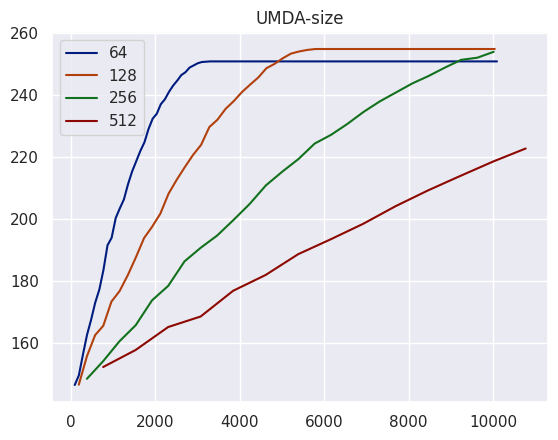

In [14]:
plt.plot(*test(UMDA, deceptive_onemax, size=64), label="64")
plt.plot(*test(UMDA, deceptive_onemax, size=128), label="128")
plt.plot(*test(UMDA, deceptive_onemax, size=256), label="256")
plt.plot(*test(UMDA, deceptive_onemax, size=512), label="512")
plt.title("UMDA-size")
plt.legend()
plt.show()

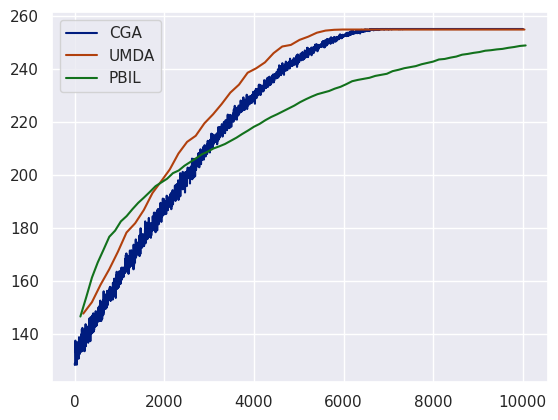

In [20]:
plt.plot(*test(CGA, deceptive_onemax, lr=0.01), label="CGA")
plt.plot(*test(UMDA, deceptive_onemax), label="UMDA")
plt.plot(*test(PBIL, deceptive_onemax, lr=0.5), label="PBIL")
plt.legend()
plt.show()